In [1]:
# load csv file and print the first 5 rows
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#df = pd.read_csv('datasets/target_model/CICIDS2017/combined_data_new_noSMOTE_0307_1.csv') # datasets\target_model\CICIDS2017\combined_data_0307_1.csv
# df


In [2]:
def Preprocess_GAN(train, label):
    # min max standardization
    # 創建一個MinMaxScaler對象
    scaler = MinMaxScaler()

    # 選擇所有數值型列，並移除"BwdPSHFlags"
    numeric_columns = list(train.select_dtypes(include=['int', "float"]).columns)
    numeric_columns.remove("BwdPSHFlags")
    numeric_columns.remove(label)
    
    # 對每一個數值型列進行縮放
    for c in numeric_columns:
        train[c] = scaler.fit_transform(train[[c]])

    # get the true label of the train set
    true_label = train[label]

    del train[label]

    return train, true_label

In [3]:
traindata = pd.read_csv('../datasets/target_model/CICIDS2018/train.csv') 
valdata = pd.read_csv('../datasets/target_model/CICIDS2018/val.csv')
testdata = pd.read_csv('../datasets/target_model/CICIDS2018/test.csv')
data = pd.concat([traindata, valdata, testdata], axis=0)
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [4]:
# X_train = traindata.iloc[:, 0:-1]   
# y_train = traindata.iloc[:, -1]
# X_val = valdata.iloc[:, 0:-1]
# y_val = valdata.iloc[:, -1]
# X_test = testdata.iloc[:, 0:-1]
# y_test = testdata.iloc[:, -1]
X_train, y_train = Preprocess_GAN(traindata, "Label")
X_val, y_val = Preprocess_GAN(valdata, "Label")
X_test, y_test = Preprocess_GAN(testdata, "Label")

In [5]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [6]:
## create dataloaders by myself
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset = ClassifierDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset = ClassifierDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())

In [7]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = y.nunique()

In [8]:
NUM_CLASSES

2

In [9]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1,drop_last=True)

In [10]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.6)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        # x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_2(x)
        # x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        # x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        # x = self.batchnorm4(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [11]:
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

###################### OUTPUT ######################
cuda:0

cpu


In [12]:
from torch import optim

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=42, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.6, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [13]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [14]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [15]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from datetime import datetime

print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_acc_score = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        #print("train_data: ", X_train_batch, y_train_batch)
        # print train data shape  
        # X_train_batch:  torch.Size([64, 42]) y_train_batch torch.Size([64]) 
        # X_train_batch:  torch.Size([batch size, feature size]) y_train_batch torch.Size([batch size])
        #print("X_train_batch: ", X_train_batch.shape, "y_train_batch", y_train_batch.shape)
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        #print("X_train_batch: ", X_train_batch, "y_train_batch", y_train_batch)
        y_train_pred = model(X_train_batch)
        #print("y_train_pred: ", y_train_pred, y_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        # caculate train accuracy score from python package
        _, y_train_pred_tags = torch.max( y_train_pred, dim = 1)
        y_train_pred_tags.cpu().numpy()
        #train_acc_score = accuracy_score(y_train_batch,  y_train_pred_tags)
        #print("train_acc_score: ", train_acc_score)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        #train_epoch_acc_score += train_acc_score
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            #print("val_data: ", X_val_batch, y_val_batch)
            y_val_pred = model(X_val_batch)
            # print("y_val_pred: ", y_val_pred, y_val_batch)          
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    avg_vloss = val_epoch_loss/len(val_loader)       
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../target_model/target_DNN_model/binaryclass/targetDNN_model_{}_{}'.format(timestamp, EPOCHS) # target_model\target_DNN_model\binaryclass
        torch.save(model.state_dict(), model_path)                           
        torch.save(model, model_path + '.pth')    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Train Acc: {train_epoch_acc_score/len(train_loader):.3f}')

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:05<04:47,  5.87s/it]

Epoch 001: | Train Loss: 0.31982 | Val Loss: 1.12507 | Train Acc: 85.638| Val Acc: 69.043


  4%|▍         | 2/50 [00:11<04:44,  5.93s/it]

Epoch 002: | Train Loss: 0.21824 | Val Loss: 0.43038 | Train Acc: 90.981| Val Acc: 76.740


  6%|▌         | 3/50 [00:17<04:36,  5.88s/it]

Epoch 003: | Train Loss: 0.18993 | Val Loss: 0.41099 | Train Acc: 92.272| Val Acc: 74.154


  8%|▊         | 4/50 [00:23<04:33,  5.94s/it]

Epoch 004: | Train Loss: 0.17485 | Val Loss: 0.45289 | Train Acc: 92.909| Val Acc: 80.000


 10%|█         | 5/50 [00:29<04:28,  5.96s/it]

Epoch 005: | Train Loss: 0.15880 | Val Loss: 1.39014 | Train Acc: 93.663| Val Acc: 68.223


 12%|█▏        | 6/50 [00:35<04:19,  5.89s/it]

Epoch 006: | Train Loss: 0.14923 | Val Loss: 0.56088 | Train Acc: 94.055| Val Acc: 71.272


 14%|█▍        | 7/50 [00:41<04:12,  5.88s/it]

Epoch 007: | Train Loss: 0.14435 | Val Loss: 0.88322 | Train Acc: 94.409| Val Acc: 73.691


 16%|█▌        | 8/50 [00:47<04:04,  5.83s/it]

Epoch 008: | Train Loss: 0.13323 | Val Loss: 1.32739 | Train Acc: 95.001| Val Acc: 70.242


 18%|█▊        | 9/50 [00:52<03:59,  5.84s/it]

Epoch 009: | Train Loss: 0.12879 | Val Loss: 1.48007 | Train Acc: 94.990| Val Acc: 67.403


 20%|██        | 10/50 [00:58<03:53,  5.83s/it]

Epoch 010: | Train Loss: 0.12249 | Val Loss: 1.89477 | Train Acc: 95.284| Val Acc: 65.636


 22%|██▏       | 11/50 [01:04<03:48,  5.86s/it]

Epoch 011: | Train Loss: 0.11910 | Val Loss: 0.77637 | Train Acc: 95.473| Val Acc: 75.079


 24%|██▍       | 12/50 [01:10<03:41,  5.83s/it]

Epoch 012: | Train Loss: 0.11510 | Val Loss: 1.07064 | Train Acc: 95.633| Val Acc: 72.576


 26%|██▌       | 13/50 [01:16<03:35,  5.82s/it]

Epoch 013: | Train Loss: 0.10982 | Val Loss: 0.84209 | Train Acc: 95.864| Val Acc: 75.268


 28%|██▊       | 14/50 [01:22<03:29,  5.82s/it]

Epoch 014: | Train Loss: 0.10692 | Val Loss: 0.65867 | Train Acc: 95.916| Val Acc: 75.499


 30%|███       | 15/50 [01:27<03:23,  5.82s/it]

Epoch 015: | Train Loss: 0.10415 | Val Loss: 0.83299 | Train Acc: 96.126| Val Acc: 72.303


 32%|███▏      | 16/50 [01:33<03:18,  5.84s/it]

Epoch 016: | Train Loss: 0.10165 | Val Loss: 0.93930 | Train Acc: 96.106| Val Acc: 73.460


 34%|███▍      | 17/50 [01:39<03:12,  5.83s/it]

Epoch 017: | Train Loss: 0.09960 | Val Loss: 2.53476 | Train Acc: 96.317| Val Acc: 53.375


 36%|███▌      | 18/50 [01:45<03:06,  5.81s/it]

Epoch 018: | Train Loss: 0.09730 | Val Loss: 0.82648 | Train Acc: 96.367| Val Acc: 75.962


 38%|███▊      | 19/50 [01:51<03:01,  5.84s/it]

Epoch 019: | Train Loss: 0.09487 | Val Loss: 3.44545 | Train Acc: 96.473| Val Acc: 54.427


 40%|████      | 20/50 [01:56<02:54,  5.82s/it]

Epoch 020: | Train Loss: 0.09235 | Val Loss: 1.48547 | Train Acc: 96.507| Val Acc: 72.576


 42%|████▏     | 21/50 [02:02<02:48,  5.81s/it]

Epoch 021: | Train Loss: 0.08926 | Val Loss: 2.00760 | Train Acc: 96.714| Val Acc: 66.961


 44%|████▍     | 22/50 [02:08<02:42,  5.80s/it]

Epoch 022: | Train Loss: 0.08873 | Val Loss: 2.64304 | Train Acc: 96.716| Val Acc: 60.631


 46%|████▌     | 23/50 [02:14<02:38,  5.89s/it]

Epoch 023: | Train Loss: 0.08662 | Val Loss: 2.75172 | Train Acc: 96.740| Val Acc: 60.904


 48%|████▊     | 24/50 [02:20<02:34,  5.93s/it]

Epoch 024: | Train Loss: 0.08636 | Val Loss: 1.91344 | Train Acc: 96.726| Val Acc: 68.980


 50%|█████     | 25/50 [02:26<02:30,  6.04s/it]

Epoch 025: | Train Loss: 0.08485 | Val Loss: 0.91070 | Train Acc: 96.870| Val Acc: 75.668


 52%|█████▏    | 26/50 [02:32<02:24,  6.03s/it]

Epoch 026: | Train Loss: 0.08426 | Val Loss: 1.23795 | Train Acc: 96.922| Val Acc: 73.922


 54%|█████▍    | 27/50 [02:38<02:17,  5.97s/it]

Epoch 027: | Train Loss: 0.08027 | Val Loss: 2.07224 | Train Acc: 97.060| Val Acc: 64.122


 56%|█████▌    | 28/50 [02:44<02:11,  5.97s/it]

Epoch 028: | Train Loss: 0.07972 | Val Loss: 1.87124 | Train Acc: 97.060| Val Acc: 69.190


 58%|█████▊    | 29/50 [02:50<02:06,  6.02s/it]

Epoch 029: | Train Loss: 0.07895 | Val Loss: 1.00637 | Train Acc: 97.006| Val Acc: 74.658


 60%|██████    | 30/50 [02:56<02:00,  6.00s/it]

Epoch 030: | Train Loss: 0.07759 | Val Loss: 0.60446 | Train Acc: 97.175| Val Acc: 79.769


 62%|██████▏   | 31/50 [03:02<01:54,  6.04s/it]

Epoch 031: | Train Loss: 0.07664 | Val Loss: 2.53639 | Train Acc: 97.145| Val Acc: 62.334


 64%|██████▍   | 32/50 [03:08<01:48,  6.04s/it]

Epoch 032: | Train Loss: 0.07738 | Val Loss: 4.43357 | Train Acc: 97.118| Val Acc: 55.163


 66%|██████▌   | 33/50 [03:14<01:41,  5.97s/it]

Epoch 033: | Train Loss: 0.07574 | Val Loss: 4.00205 | Train Acc: 97.213| Val Acc: 55.836


 68%|██████▊   | 34/50 [03:20<01:34,  5.94s/it]

Epoch 034: | Train Loss: 0.07386 | Val Loss: 3.26553 | Train Acc: 97.205| Val Acc: 59.369


 70%|███████   | 35/50 [03:26<01:28,  5.89s/it]

Epoch 035: | Train Loss: 0.07359 | Val Loss: 1.42312 | Train Acc: 97.272| Val Acc: 71.672


 72%|███████▏  | 36/50 [03:32<01:21,  5.85s/it]

Epoch 036: | Train Loss: 0.07233 | Val Loss: 1.95361 | Train Acc: 97.311| Val Acc: 69.485


 74%|███████▍  | 37/50 [03:38<01:16,  5.87s/it]

Epoch 037: | Train Loss: 0.07206 | Val Loss: 1.66985 | Train Acc: 97.361| Val Acc: 72.219


 76%|███████▌  | 38/50 [03:43<01:10,  5.84s/it]

Epoch 038: | Train Loss: 0.07242 | Val Loss: 0.81945 | Train Acc: 97.287| Val Acc: 76.025


 78%|███████▊  | 39/50 [03:49<01:04,  5.83s/it]

Epoch 039: | Train Loss: 0.07125 | Val Loss: 0.58966 | Train Acc: 97.386| Val Acc: 78.318


 80%|████████  | 40/50 [03:55<00:58,  5.82s/it]

Epoch 040: | Train Loss: 0.07145 | Val Loss: 0.55388 | Train Acc: 97.413| Val Acc: 77.918


 82%|████████▏ | 41/50 [04:01<00:52,  5.82s/it]

Epoch 041: | Train Loss: 0.06909 | Val Loss: 0.85140 | Train Acc: 97.461| Val Acc: 74.974


 84%|████████▍ | 42/50 [04:07<00:46,  5.85s/it]

Epoch 042: | Train Loss: 0.07172 | Val Loss: 0.77757 | Train Acc: 97.334| Val Acc: 74.132


 86%|████████▌ | 43/50 [04:13<00:40,  5.85s/it]

Epoch 043: | Train Loss: 0.06819 | Val Loss: 0.73896 | Train Acc: 97.467| Val Acc: 75.289


 88%|████████▊ | 44/50 [04:18<00:35,  5.83s/it]

Epoch 044: | Train Loss: 0.06791 | Val Loss: 0.50816 | Train Acc: 97.401| Val Acc: 80.042


 90%|█████████ | 45/50 [04:24<00:29,  5.83s/it]

Epoch 045: | Train Loss: 0.06721 | Val Loss: 2.92489 | Train Acc: 97.446| Val Acc: 64.543


 92%|█████████▏| 46/50 [04:30<00:23,  5.82s/it]

Epoch 046: | Train Loss: 0.06802 | Val Loss: 3.01862 | Train Acc: 97.448| Val Acc: 63.512


 94%|█████████▍| 47/50 [04:36<00:17,  5.81s/it]

Epoch 047: | Train Loss: 0.06635 | Val Loss: 2.62957 | Train Acc: 97.536| Val Acc: 65.342


 96%|█████████▌| 48/50 [04:42<00:11,  5.85s/it]

Epoch 048: | Train Loss: 0.06479 | Val Loss: 3.05492 | Train Acc: 97.663| Val Acc: 63.764


 98%|█████████▊| 49/50 [04:48<00:05,  5.84s/it]

Epoch 049: | Train Loss: 0.06685 | Val Loss: 2.45891 | Train Acc: 97.513| Val Acc: 66.604


100%|██████████| 50/50 [04:53<00:00,  5.88s/it]

Epoch 050: | Train Loss: 0.06580 | Val Loss: 0.97875 | Train Acc: 97.590| Val Acc: 72.492


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

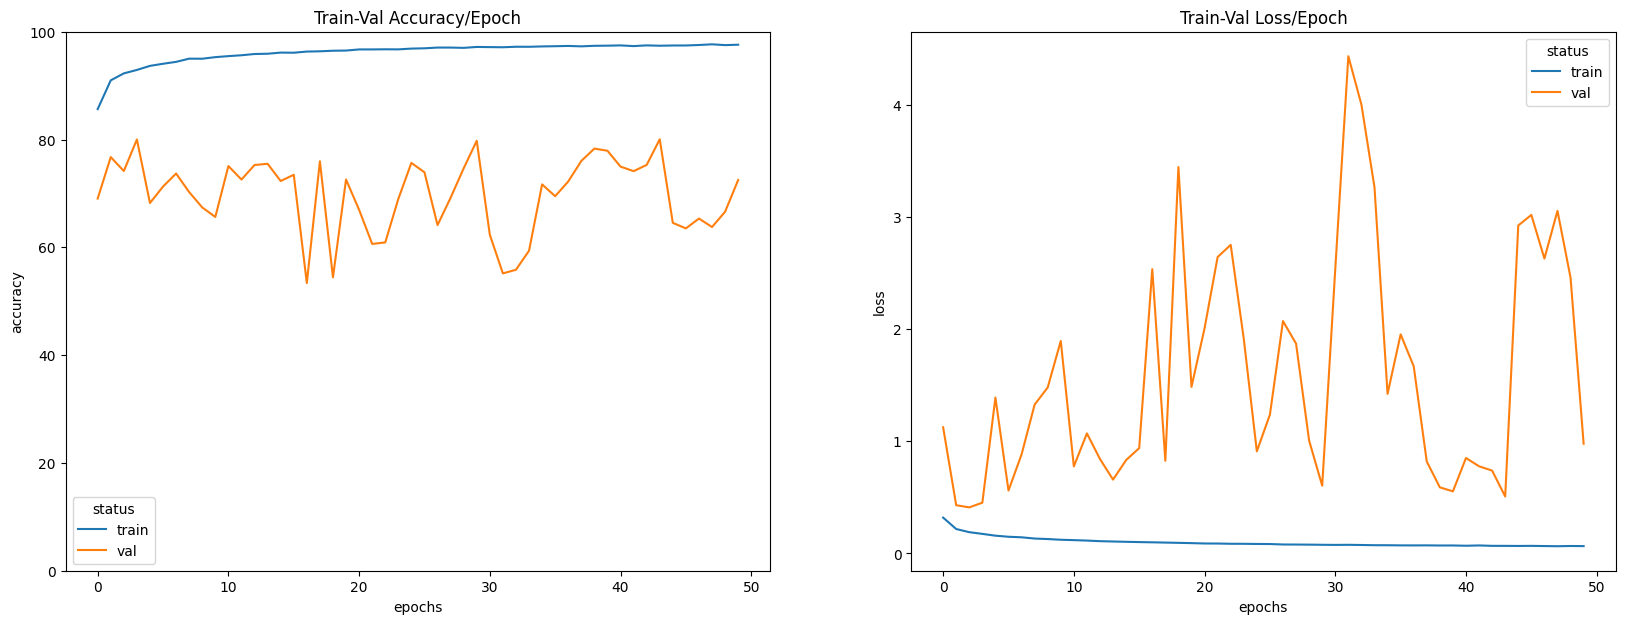

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# modify column names
train_val_acc_df.columns = ['epochs', 'status', 'accuracy']
train_val_loss_df.columns = ['epochs', 'status', 'loss']
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="accuracy", hue="status",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
# change the limits of y-axis
axes[0].set_ylim(0, 100) 
sns.lineplot(data=train_val_loss_df, x = "epochs", y="loss", hue="status", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [25]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        #print(_, y_pred_tags.cpu().numpy())
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
y_test.shape

(11886,)

In [19]:
len(y_pred_list)

11886

In [26]:
# test accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(y_test, y_pred_list))

0.7114252061248527


In [27]:
y_test = y_test
print(classification_report(y_test, y_pred_list, target_names=['Benign', 'Malicious'], digits=4))

              precision    recall  f1-score   support

      Benign     0.6710    0.8351    0.7441      5972
   Malicious     0.7789    0.5866    0.6692      5914

    accuracy                         0.7114     11886
   macro avg     0.7249    0.7108    0.7066     11886
weighted avg     0.7247    0.7114    0.7068     11886



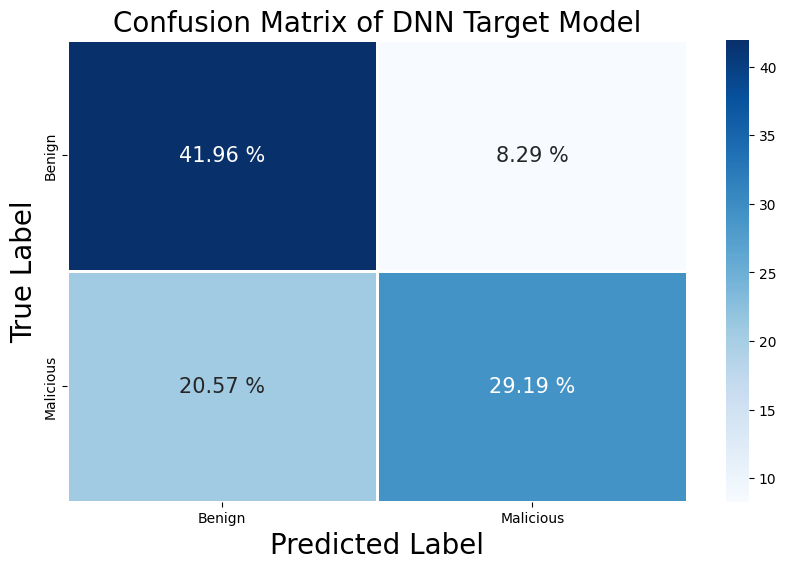

In [29]:
cm = confusion_matrix(y_test, y_pred_list, labels=data['Label'].unique() )
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of DNN Target Model', fontsize=20)
plt.show()